In [1]:
import uproot
import numpy as np
import torch
from collections import defaultdict
from util import get_layer, theta_func,create_layer_map
from reco import calculate_num_pixels_z_dependence
import matplotlib.pyplot as plot
import time
from collections import defaultdict
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)
from IPython.display import clear_output
from tqdm import tqdm
from torch import nn

Using device cuda:0


In [3]:
import normflows as nf
import datetime
x = datetime.datetime.now()
today = x.strftime("%B_%d")
# particle = "pi"
particle = "mu"

# This data will be used for storing plots - today above works if you actually want today
# today = "July_26"

run_num = 7
run_num_str = str(run_num)

#NF Stuff

K = 8 #num flows

latent_size = 1 #dimension of PDF
hidden_units = 256 #nodes in hidden layers
hidden_layers = 26
context_size = 3 #conditional variables for PDF
num_context = 3

K_str = str(K)
batch_size= 2000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)
# model_date = "August_03"
# today = "August_03"
# model_path = "models/" + model_date + "/"
# checkdir(model_path)

model_path = "/hpc/group/vossenlab/rck32/NF_time_res_models/"

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")
model = model.to(device)
model_compile = torch.compile(model,mode = "reduce-overhead")
model_compile = model_compile.to(device)

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/normflows/core.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [8]:
layer_map, super_layer_map = create_layer_map()


def process_root_file(file_path):
    print("began processing")
    with uproot.open(file_path) as file:
        tree_HcalBarrelHits = file["events/HcalBarrelHits"]
        tree_MCParticles = file["events/MCParticles"]
        
        
        momentum_x_MC = tree_MCParticles["MCParticles.momentum.x"].array(library="np")
        momentum_y_MC = tree_MCParticles["MCParticles.momentum.y"].array(library="np")
        momentum_z_MC = tree_MCParticles["MCParticles.momentum.z"].array(library="np")
        
        z_pos = tree_HcalBarrelHits["HcalBarrelHits.position.z"].array(library="np")
        x_pos = tree_HcalBarrelHits["HcalBarrelHits.position.x"].array(library="np")
        energy = tree_HcalBarrelHits["HcalBarrelHits.EDep"].array(library="np")
        momentum_x = tree_HcalBarrelHits["HcalBarrelHits.momentum.x"].array(library="np")
        momentum_y = tree_HcalBarrelHits["HcalBarrelHits.momentum.y"].array(library="np")
        momentum_z = tree_HcalBarrelHits["HcalBarrelHits.momentum.z"].array(library="np")
        hit_time = tree_HcalBarrelHits["HcalBarrelHits.time"].array(library="np")
        mc_hit_idx = file["events/_HcalBarrelHits_MCParticle/_HcalBarrelHits_MCParticle.index"].array(library="np")  # Add PDG code for particle identification
        print("finished loading branches")
        
        processed_data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
        
        for event_idx in tqdm(range(len(z_pos))):
            energy_per_layer_particle = defaultdict(lambda: defaultdict(float))
            first_hit_per_layer_particle = defaultdict(dict)
            primary_momentum = (momentum_x_MC[event_idx][0],
                            momentum_y_MC[event_idx][0],
                            momentum_z_MC[event_idx][0])
            primary_momentum_mag = np.linalg.norm(primary_momentum)
            # First pass: collect first hit data and calculate energy per layer per particle
            for hit_idx in range(len(z_pos[event_idx])):
                z = z_pos[event_idx][hit_idx]
                x = x_pos[event_idx][hit_idx]
                e = energy[event_idx][hit_idx]
                momentum = (momentum_x[event_idx][hit_idx],
                            momentum_y[event_idx][hit_idx],
                            momentum_z[event_idx][hit_idx])
                momentum_mag = np.linalg.norm(momentum)
                theta = theta_func(momentum_x[event_idx][hit_idx], momentum_y[event_idx][hit_idx], momentum_z[event_idx][hit_idx])
                layer = get_layer(x)
                particle_id = mc_hit_idx[event_idx][hit_idx]
                
                energy_per_layer_particle[layer][particle_id] += e
                
                if layer not in first_hit_per_layer_particle or particle_id not in first_hit_per_layer_particle[layer]:
                    first_hit_per_layer_particle[layer][particle_id] = {
                        "z_pos": z,
                        "x_pos": x,
                        "momentum": momentum_mag,
                        "primary_momentum": primary_momentum_mag,
                        "theta": theta,
                        "time": hit_time[event_idx][hit_idx],
                        "mc_hit_idx": particle_id
                    }
            
            
            # Second pass: process first hit with total layer energy per particle
            for layer, particle_data in first_hit_per_layer_particle.items():
                for particle_id, hit_data in particle_data.items():
                    layer_particle_energy = energy_per_layer_particle[layer][particle_id]
                    num_pixels = calculate_num_pixels_z_dependence(layer_particle_energy, hit_data["z_pos"])
#                     print(f"layer:\t\t{layer}\t|\tparticle id:\t{particle_id}\t|\tnum_pixels:\t{num_pixels}")
                    hit_data["num_pixels"] = int(np.floor(num_pixels))
                    hit_data["layer_energy"] = layer_particle_energy  # Store total layer energy for this particle
                    processed_data[event_idx][layer][particle_id.item()] = hit_data
            if(event_idx > 50):
                break
    
    print("finished processing")
    return processed_data

In [9]:
pref = "/hpc/group/vossenlab/rck32/"
# processed_data = process_root_file(pref + "eic/work_eic/root_files/September_3/sector_scint/run_1_pip_0_8_10GeV_theta_90_500events.edm4hep.root")
# processed_data = process_root_file(pref + "eic/work_eic/root_files/September_3/sector_scint/run_1_mum_0_8_10GeV_theta_90_500events.edm4hep.root")
processed_data = process_root_file(pref + "eic/work_eic/root_files/September_3/sector_scint/run_1_n_0_8_10GeV_theta_90_5kevents.edm4hep.root")
# nn_input, nn_output = prepare_nn_input(processed_data, normalizing_flow_model)
# prediction_input, prediction_output = prepare_prediction_input(nn_input, nn_output)

began processing
finished loading branches


  1%|          | 51/5000 [00:00<00:29, 166.41it/s]

finished processing


In [10]:
def prepare_nn_input(processed_data, normalizing_flow, batch_size=1024):
    flattened_data = []
    event_indices = []
    layer_indices = []
    particle_indices = []

    final_event_indices = []
    final_layer_indices = []
    final_particle_indices = []
    
    momentum_list = []
    
    context_list = []
    running_pixel_idx = 0
    for event_idx, event_data in processed_data.items():
        for layer, layer_data in event_data.items():
            for particle_id, particle_data in layer_data.items():
                primary_momentum = particle_data["primary_momentum"]
                context = torch.tensor([particle_data['z_pos'], particle_data['theta'], particle_data['momentum']], dtype=torch.float32).repeat(particle_data['num_pixels'], 1)
                flattened_data.append(torch.tensor([particle_data['time'], particle_data['num_pixels']]).repeat(particle_data['num_pixels'],1))
                context_list.append(context)
                for pixel_repeat_idx in range(particle_data['num_pixels']):
                    final_event_indices.append(event_idx)
                    final_layer_indices.append(layer)
                    final_particle_indices.append(particle_id)
                    momentum_list.append(primary_momentum.item())
    all_context = torch.cat(context_list).to(device)
    all_time_pixels = torch.cat(flattened_data)
    # Batch the flattened data
    max_its = int(np.ceil(all_context.shape[0] / batch_size))
    sampled_data = []
    print("Beginning sampling process")
    for batch_idx in tqdm(range(max_its)):
        begin = batch_idx * batch_size
        data_left = all_context.shape[0] - (batch_idx * batch_size)
        end = min(begin + batch_size,begin + data_left)
        add_times = all_time_pixels[begin:end]
        context_batch = all_context[begin:end].to(device)
        with torch.no_grad():
            samples = abs(normalizing_flow.sample(num_samples=context_batch.shape[0], context=context_batch)[0]).squeeze(1)
        adjusted_times = samples.detach().cpu() + add_times[:,0]
        sampled_data.extend(adjusted_times)
    # Reorganize sampled data
    nn_input = defaultdict(lambda: defaultdict(list))
    nn_output = defaultdict(lambda: defaultdict(list))
    print("Beginning reorganization process")
    for i, (event, layer, particle) in enumerate(zip(final_event_indices, final_layer_indices, final_particle_indices)):
        nn_input[event][layer].append(sampled_data[i])
        nn_output[event][layer].append(torch.Tensor([momentum_list[i]]))
    return nn_input, nn_output

In [11]:
begin = time.time()
nn_input, nn_output = prepare_nn_input(processed_data, model_compile,batch_size = 50000)
end = time.time()

Beginning sampling process


100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


Beginning reorganization process


In [ ]:
print(f"rate: {(end - begin) / 5000} seconds / event")

In [26]:
import numpy as np
from scipy import signal

class SiPMSignalProcessor:
    def __init__(self, 
                 sampling_rate=40e9,  # 40 GHz sampling rate
                 tau_rise=1e-9,       # 1 ns rise time
                 tau_fall=50e-9,      # 50 ns fall time
                 window=200e-9,       # 200 ns time window
                 cfd_delay=5e-9,      # 5 ns delay for CFD
                 cfd_fraction=0.3):   # 30% fraction for CFD
        
        self.sampling_rate = sampling_rate
        self.tau_rise = tau_rise
        self.tau_fall = tau_fall
        self.window = window
        self.cfd_delay = cfd_delay
        self.cfd_fraction = cfd_fraction
        
        # Time array for single pulse shape
        self.time = np.arange(0, self.window, 1/self.sampling_rate)
        
        # Generate single pulse shape
        self.pulse_shape = self._generate_pulse_shape()
    
    def _generate_pulse_shape(self):
        """Generate normalized pulse shape for a single photon"""
        shape = (1 - np.exp(-self.time/self.tau_rise)) * np.exp(-self.time/self.tau_fall)
        return shape / np.max(shape)  # Normalize
    
    def generate_waveform(self, photon_times):
        """Generate waveform from list of photon arrival times"""
        # Initialize waveform array
        waveform = np.zeros_like(self.time)
        
        # Add pulse for each photon
        for t in photon_times:
            if 0 <= t < self.window:
                idx = int(t * self.sampling_rate)
                remaining_samples = len(self.time) - idx
                waveform[idx:] += self.pulse_shape[:remaining_samples]
        
        return self.time, waveform
    
    def integrate_charge(self, waveform, integration_start=0, integration_time=100e-9):
        """Integrate charge in specified time window"""
        start_idx = int(integration_start * self.sampling_rate)
        end_idx = int((integration_start + integration_time) * self.sampling_rate)
        
        # Integrate using trapezoidal rule
        charge = np.trapezoid(waveform[start_idx:end_idx], dx=1/self.sampling_rate)
        return charge
    
    def cfd_timing(self, waveform):
        """Implement Constant Fraction Discrimination timing"""
        # Create delayed and attenuated versions
        delay_samples = int(self.cfd_delay * self.sampling_rate)
        delayed = np.roll(waveform, delay_samples)
        attenuated = waveform * self.cfd_fraction
        
        # CFD waveform
        cfd_signal = attenuated - delayed
        
        # Find zero crossing
        zero_crossings = np.where(np.diff(np.signbit(cfd_signal)))[0]
        
        if len(zero_crossings) > 0:
            # Linear interpolation for more precise timing
            idx = zero_crossings[0]
            t1, t2 = self.time[idx], self.time[idx+1]
            v1, v2 = cfd_signal[idx], cfd_signal[idx+1]
            
            # Time at zero crossing
            zero_time = t1 - v1 * (t2 - t1) / (v2 - v1)
            return zero_time
        else:
            return None

In [27]:
def prepare_prediction_input(nn_input, nn_output):
    processor = SiPMSignalProcessor()
    
    #note - some events do not have dictionaries in nn_input due to being empty
    #need to skip over these and condense tensor
    prediction_input = torch.ones(len(nn_input),28,2) * 9999
    prediction_output = torch.ones(len(nn_input)) * 9999
    
    input_dict = defaultdict(lambda: defaultdict(list))
    output_dict = {}
    curr_event_num = 0
    for event_idx in tqdm(list(nn_input)):
        event_input = []
        set_output = False
        layer_keys = nn_input[event_idx].keys()
        for layer in range(28):
            if(layer in layer_keys):
                photon_times = torch.tensor(sorted(nn_input[event_idx][layer])) * 10 **(-9)
                #get relative times
                min_time = photon_times[0]
                photon_times = photon_times - min_time
                
                #calculate time and charge
                time,waveform = processor.generate_waveform(photon_times)
                charge = processor.integrate_charge(waveform)
                timing = processor.cfd_timing(waveform)
                if(not set_output):
                    prediction_output[curr_event_num] = nn_output[event_idx][layer][0]
                    set_output = True
            else:
                charge = 0
                timing = 9999

            prediction_input[curr_event_num][layer][0] = charge
            prediction_input[curr_event_num][layer][1] = timing + min_time
        curr_event_num += 1
    return prediction_input, prediction_output


In [29]:
#demo
processor = SiPMSignalProcessor()    
photon_times = torch.tensor(sorted(nn_input[0][1])) * 10 **(-9)
#get relative times
min_time = photon_times[0]
photon_times = photon_times - min_time
time,waveform = processor.generate_waveform(photon_times)
charge = processor.integrate_charge(waveform)
timing = processor.cfd_timing(waveform)

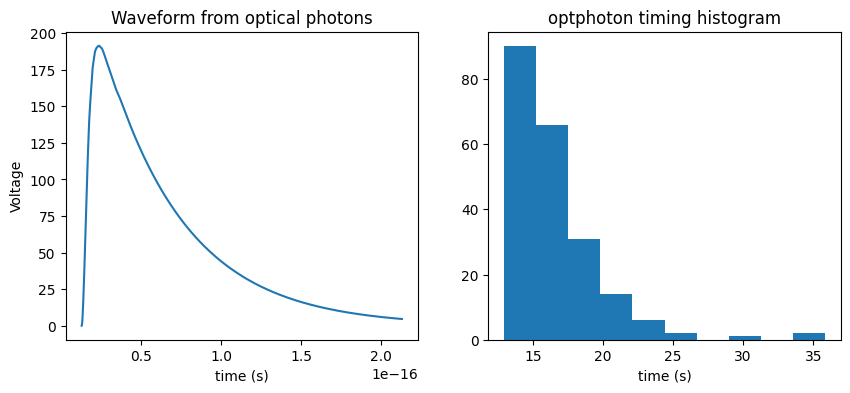

In [47]:
fig, axs = plot.subplots(1,2,figsize = (10,4))
convert_time = (time + min_time.item()) * 10 ** (-9)
axs[0].plot(convert_time,waveform);
axs[1].hist(nn_input[0][1],bins = 10);
axs[1].set_title("optphoton timing histogram")
axs[0].set_xlabel("time (s)")
axs[1].set_xlabel("time (s)")
axs[0].set_ylabel("Voltage")
axs[0].set_title("Waveform from optical photons")
plot.show()
fig.savefig("waveform.pdf")

In [133]:
prediction_input, prediction_output= prepare_prediction_input(nn_input,nn_output)

100%|██████████| 4980/4980 [46:35<00:00,  1.78it/s]  


In [2]:
class Predictor(nn.Module):
    """
    Prediction network
    """
    def __init__(self, input_size=56, num_classes=2, hidden_dim = 512, num_layers = 10):
        super(Predictor, self).__init__()
        self.layer = nn.Sequential()
        for i in range(num_layers):
            if(i == 0):
                self.layer.append(
                nn.Linear(input_size, hidden_dim)
                )
                self.layer.append(
                    nn.LeakyReLU(inplace=True)
                )
            elif(i == num_layers - 1):
                self.layer.append(
                nn.Linear(hidden_dim, num_classes)
                )
            else:
                self.layer.append(
                    nn.Linear(hidden_dim, hidden_dim)
                )
                self.layer.append(
                    nn.LeakyReLU(inplace=True)
                )
        self.name = "Predictor"
#         self.double()
        
    def forward(self, h):
        c = self.layer(h)
        return c
    
    # @property
    def name(self):
        """
        Name of model.
        """
        return self.name

In [3]:
def split_data(inputs, outputs, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Split data into training, validation, and test sets.
    
    Parameters:
    inputs (torch.Tensor): Input tensor of shape (n_samples, ...)
    outputs (torch.Tensor): Output tensor of shape (n_samples, ...)
    train_ratio (float): Ratio of data to use for training (default: 0.7)
    val_ratio (float): Ratio of data to use for validation (default: 0.15)
    test_ratio (float): Ratio of data to use for testing (default: 0.15)
    seed (int): Random seed for reproducibility
    
    Returns:
    dict: Dictionary containing the split data
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"
    assert inputs.shape[0] == outputs.shape[0], "Number of inputs and outputs must match"
    
    # Set seed for reproducibility
    torch.manual_seed(seed)
    
    # Get total number of samples
    num_samples = inputs.shape[0]
    indices = torch.randperm(num_samples)
    
    # Calculate split points
    train_end = int(num_samples * train_ratio)
    val_end = train_end + int(num_samples * val_ratio)
    
    # Split indices
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]
    
    # Create splits
    train_data = {
        'inputs': inputs[train_indices],
        'outputs': outputs[train_indices]
    }
    
    val_data = {
        'inputs': inputs[val_indices],
        'outputs': outputs[val_indices]
    }
    
    test_data = {
        'inputs': inputs[test_indices],
        'outputs': outputs[test_indices]
    }
    
    split_info = {
        'train_size': len(train_indices),
        'val_size': len(val_indices),
        'test_size': len(test_indices)
    }
    
    return train_data, val_data, test_data, split_info

In [4]:
def train(predictor, train_data, nn_output,val_data, val_out, optimizer, device, num_epochs=18, batch_size=100, show_progress=True):
    criterion = nn.MSELoss()
    predictor.train()
    total_data_points = train_data.shape[0]
    indices = torch.arange(total_data_points)
    num_it = total_data_points // batch_size
    loss_hist = []
    
    for epoch in range(num_epochs):
        # Shuffle data at the start of each epoch
        shuffle_indices = torch.randperm(total_data_points)
        shuffled_data = train_data[shuffle_indices]
        shuffled_output = nn_output[shuffle_indices]
        
        epoch_losses = []
        clear_output(wait = True)
        print(f"Training epoch #{epoch}")
        
        with tqdm(total=num_it, position=0, leave=True) as pbar:
            for it in range(num_it):
                optimizer.zero_grad()

                # Correct batch indexing
                begin = it * batch_size
                end = min(begin + batch_size, total_data_points)

                context_inputs = shuffled_data[begin:end].flatten(start_dim=1).to(device)
                expected_outputs = shuffled_output[begin:end].unsqueeze(-1).to(device)

                outputs = predictor(context_inputs)
                loss = criterion(outputs, expected_outputs)

                # Check for invalid loss
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: Invalid loss at iteration {it}")
                    continue

                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                if show_progress:
                    pbar.update(1)

            # Record average loss for the epoch
            avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
            loss_hist.append(avg_epoch_loss)
            print(f"Epoch {epoch} average loss: {avg_epoch_loss:.4f}")
    
    print('Finished Training')
    return loss_hist

In [5]:
def train(predictor, train_data, nn_output, val_data, val_out, optimizer, device, 
          num_epochs=18, batch_size=100, show_progress=True, patience=5):
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training Phase
        predictor.train()
        total_data_points = train_data.shape[0]
        num_it = total_data_points // batch_size
        epoch_losses = []
        
        # Shuffle training data
        shuffle_indices = torch.randperm(total_data_points)
        shuffled_data = train_data[shuffle_indices]
        shuffled_output = nn_output[shuffle_indices]
        
        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training loop
        with tqdm(total=num_it, position=0, leave=True) as pbar:
            for it in range(num_it):
                optimizer.zero_grad()
                begin = it * batch_size
                end = min(begin + batch_size, total_data_points)
                
                context_inputs = shuffled_data[begin:end].flatten(start_dim=1).to(device)
                expected_outputs = shuffled_output[begin:end].unsqueeze(-1).to(device)
                
                outputs = predictor(context_inputs)
                loss = criterion(outputs, expected_outputs)
                
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: Invalid loss at iteration {it}")
                    continue
                    
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())
                
                if show_progress:
                    pbar.update(1)
        
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        
        # Validation Phase
        predictor.eval()
        val_epoch_losses = []
        with torch.no_grad():
            # Process validation data in batches
            val_data_points = val_data.shape[0]
            val_iterations = val_data_points // batch_size + (1 if val_data_points % batch_size != 0 else 0)
            
            for it in range(val_iterations):
                begin = it * batch_size
                end = min(begin + batch_size, val_data_points)
                
                val_inputs = val_data[begin:end].flatten(start_dim=1).to(device)
                val_expected = val_out[begin:end].unsqueeze(-1).to(device)
                
                val_outputs = predictor(val_inputs)
                val_loss = criterion(val_outputs, val_expected)
                val_epoch_losses.append(val_loss.item())
        
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = predictor.state_dict()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            predictor.load_state_dict(best_model_state)  # Restore best model
            break
    
    print('Finished Training')
    return train_losses, val_losses


Cutting out bad data that has output = 9999 and putting good data in oct_6

In [51]:
# for file_num in range(51):
#     test_in = torch.load(f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/input_5k_n_slurm_{file_num}.pt",weights_only = True)
#     test_out = torch.load(f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/output_5k_n_slurm_{file_num}.pt",weights_only = True)
#     for i in range(len(test_out)):
#         if(test_out[i] == 9999):
#             print(f"file #{file_num}, event #{i}")

In [48]:
# file_num = 50
# test_in = torch.load(f"data/momentum_prediction_pulse/Oct_3/input_5k_n_slurm_{file_num}.pt",weights_only = True)
# test_out = torch.load(f"data/momentum_prediction_pulse/Oct_3/output_5k_n_slurm_{file_num}.pt",weights_only = True)

In [49]:
# cut_inputs = torch.cat((test_in[:3085],test_in[3086:]))
# cut_outputs = torch.cat((test_out[:3085],test_out[3086:]))

In [50]:
# torch.save(cut_inputs,f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/input_5k_n_slurm_{file_num}.pt")
# torch.save(cut_outputs,f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/output_5k_n_slurm_{file_num}.pt")

In [52]:
inputs = torch.load("data/momentum_prediction_pulse/Oct_6_cut_bad_events/input_5k_n_slurm_0.pt",weights_only = True)
outputs = torch.load("data/momentum_prediction_pulse/Oct_6_cut_bad_events/output_5k_n_slurm_0.pt",weights_only = True)
for i in range(1,51):
    new_input = torch.load(f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/input_5k_n_slurm_{i}.pt",weights_only = True)
    inputs = torch.cat((inputs,new_input))
    new_output = torch.load(f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/output_5k_n_slurm_{i}.pt",weights_only = True)
    outputs = torch.cat((outputs,new_output))

In [53]:
scaled_inputs = inputs
for i in range(len(inputs)):
    for j in range(len(inputs[i])):
        if(inputs[i][j][1] == 9999):
            scaled_inputs[i][j][1] = 0
        scaled_inputs[i][j][0] *= 1e6 
        scaled_inputs[i][j][1] *= 1e8

In [54]:
train_data, val_data, test_data, split_info = split_data(
    scaled_inputs, outputs
)

In [85]:
from torch import nn
from reco import Predictor
num_layers = 28
num_input_features_per_layer = 2
model = Predictor(input_size=num_layers * num_input_features_per_layer, num_classes=1, hidden_dim = num_layers * num_input_features_per_layer * 2, num_layers = 16)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [86]:
loss_hist,val_hist = train(model,train_data['inputs'],train_data['outputs'],val_data['inputs'],val_data['outputs'],optimizer,device,num_epochs = 200, batch_size = 256)

Epoch 151/200


100%|██████████| 694/694 [00:02<00:00, 295.74it/s]


Epoch 151 - Train Loss: 1.1848, Val Loss: 1.2093
Early stopping triggered after epoch 151
Finished Training


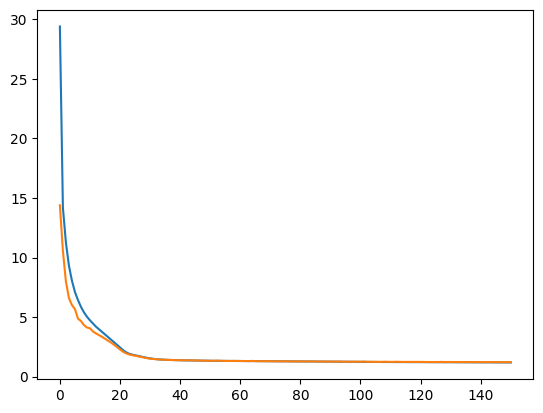

In [87]:
plot.plot(loss_hist);
plot.plot(val_hist);

In [88]:
def calculate_metrics(y_true, y_pred):

    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mse = np.mean((y_true - y_pred) ** 2)  # Mean Squared Error
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    # R-squared calculation
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r_squared': r_squared
    }

In [89]:
dataset = test_data
model_out = np.zeros(len(dataset['outputs']))
for i in range(len(model_out)):
    model_out[i] = model(dataset['inputs'][i].flatten().to(device)).detach().cpu()
    

In [118]:
num_bins = 20
bin_edges = np.linspace(0,10,num_bins + 1)

binned_model_out = [[] for _ in range(num_bins)]
binned_real_out = [[] for _ in range(num_bins)]
dataset = test_data
real_out = dataset['outputs']
model_out = np.zeros(len(real_out))
for i in range(len(model_out)):
    model_out[i] = model(dataset['inputs'][i].flatten().to(device)).detach().cpu()
    for j in range(1,len(bin_edges)):
        if(real_outs[i] < bin_edges[j]):
            binned_model_out[j - 1].append(model_out[i])
            binned_real_out[j - 1].append(real_out[i])
            break
binned_real_out = np.array(binned_real_out)
binned_model_out = np.array(binned_model_out)

In [119]:
bin_centers = np.array(bin_edges[1:]) - (bin_edges[1] - bin_edges[0]) / 2

In [125]:
RMSE_arr = np.zeros(len(bin_centers))
for i in range(len(bin_centers)):
    mse = np.mean((np.array(binned_real_out[i]) - np.array(binned_model_out[i])) ** 2)  # Mean Squared Error
    RMSE_arr[i] = np.sqrt(mse)  # Root Mean Squared Error

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [156]:
def fit_func(e,a,c):
    return a / np.sqrt(e)  + c

from scipy import optimize
popt,pcov = optimize.curve_fit(fit_func,bin_centers[1:],RMSE_arr[1:] / bin_centers[1:] )

fitted_rel_RMSE = np.zeros(len(bin_centers) - 1)
for i in range(1,len(bin_centers)):
    fitted_rel_RMSE[i - 1] = fit_func(bin_centers[i],*popt)

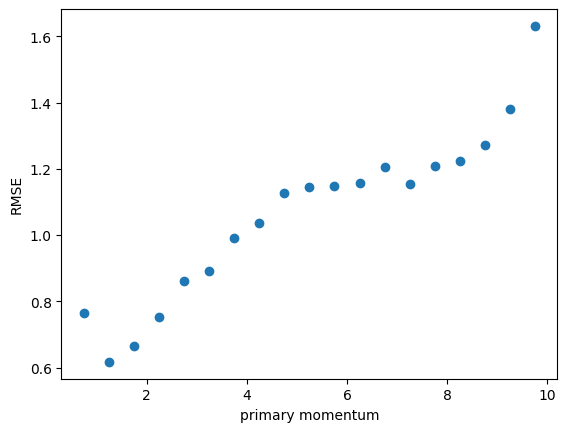

In [161]:
plot.scatter(bin_centers[1:],RMSE_arr[1:])
# plot.plot(bin_centers[1:],fitted_rel_RMSE,color = "red")
plot.xlabel("primary momentum")
plot.ylabel("RMSE")
plot.show();
# plot.savefig("fit_rel_RMSE.jpeg")

In [159]:
# print(f"a,b,c: %.2f,%.2f,%.2f"%(popt[0],popt[1],popt[2]))
print(f"a,c: %.2f,%.2f"%(popt[0],popt[1]))

a,c: 0.87,-0.17


In [90]:
# Regression example
true_values = dataset['outputs']
pred_values = model_out
reg_metrics = calculate_metrics(true_values, pred_values)
print("\nRegression Metrics:")
print(f"Mean Squared Error: {reg_metrics['mse']:.4f}")
print(f"Root Mean Squared Error: {reg_metrics['rmse']:.4f}")
print(f"Mean Absolute Error: {reg_metrics['mae']:.4f}")
print(f"R-squared: {reg_metrics['r_squared']:.4f}")


Regression Metrics:
Mean Squared Error: 1.2187
Root Mean Squared Error: 1.1039
Mean Absolute Error: 0.8094
R-squared: 0.8264


(0.0, 10.0)

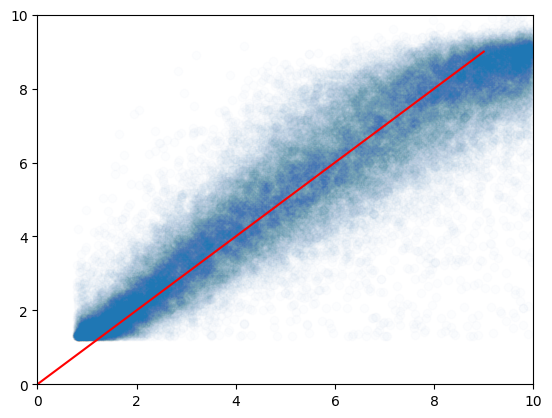

In [91]:
plot.scatter(dataset['outputs'],model_out, alpha = 0.01)
plot.plot(range(10),color = "red");
plot.ylim(0,10)
plot.xlim(0,10)